У Цьому проекті я проведу аналіз часових рядів на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Задача дещо змінена, працювати буду тільки з тренувальними даними. Фокус задачі на пошуку найкращої моделі, експериментах з часовими рядами і використання функціоналу `darts`.

Надано дані про продажі товарів у магазинах за 5 років. Хочу навчитись передбачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього. Для цього виберу 1 товар з одного магазину і на ньому буду проводити експерименти.

На відміну від змагання, буду використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error).

1. Завантажуо дані в Pandas.

  1. Завантажую дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворюю колонку `date` на формат `datetime`.
  3. Встановлюю колонку `date` як індекс для датафрейму.
  4. Виводжу перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns

In [2]:
!unzip "train.csv.zip"

Archive:  train.csv.zip
  inflating: train.csv               


In [3]:
data = pd.read_csv('train.csv')

In [4]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

In [5]:
data[:10]

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


In [6]:
data

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


In [8]:
data.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Побудую графіки, які допоможуть продажі помагазинно та потоварно.




Побудую boxplot, який покаже продажі по магазинах, з візуалізацією середніх продаж, викидів та IQR по продажах

<Figure size 1200x600 with 0 Axes>

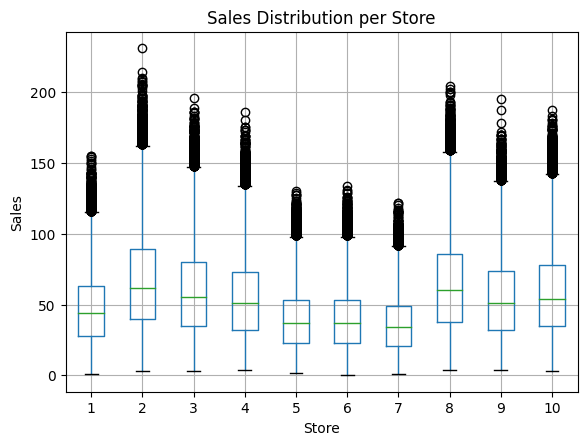

In [9]:
plt.figure(figsize=(12, 6))
data.boxplot(column='sales', by='store')
plt.title('Sales Distribution per Store')
plt.xlabel('Store')
plt.ylabel('Sales')
plt.suptitle('')  # Видалити дублюючий заголовок
plt.show()


Судячи по цьому боксплоту видно, що найкраще продажі йдуть у магазинах 2, 3, 8, 10.
Вони показуть найкращі середні продажі та найбільший діапазон IQR

Цей scatterplot показує середні продажі кожного товару по магазинах

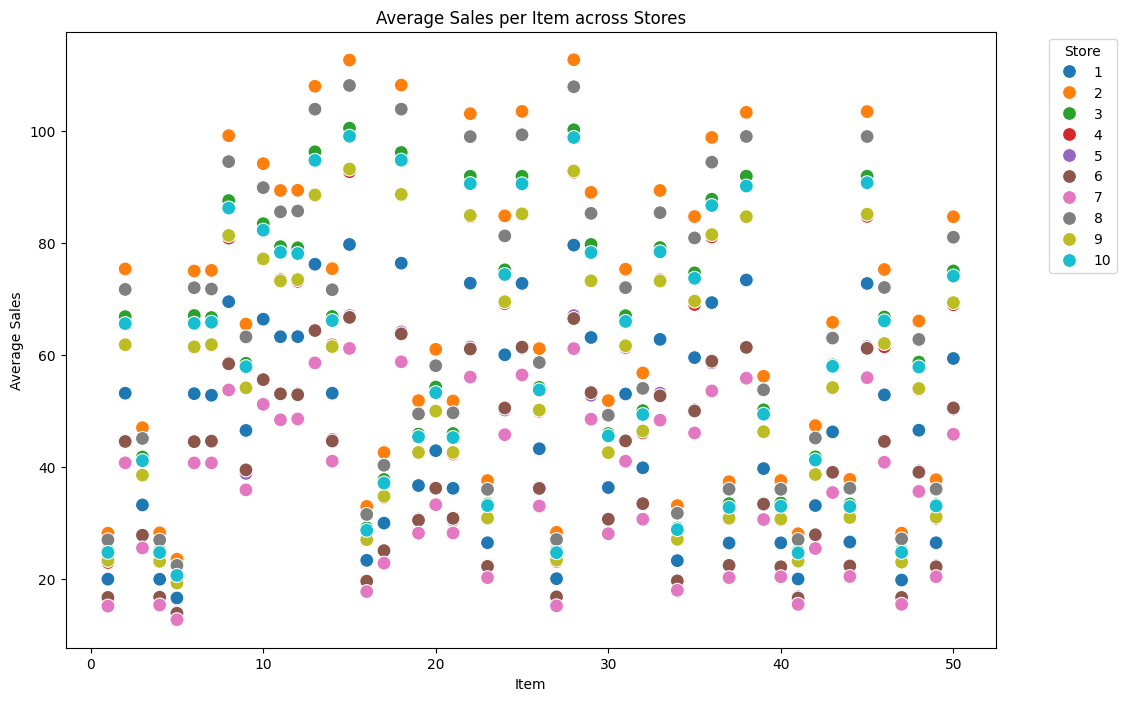

In [10]:
mean_sales = data.groupby(['store', 'item'])['sales'].mean().reset_index()

# Побудова scatterplot для середніх продажів
plt.figure(figsize=(12, 8))
sns.scatterplot(data=mean_sales, x='item', y='sales', hue='store', palette='tab10', s=100)
plt.title('Average Sales per Item across Stores')
plt.xlabel('Item')
plt.ylabel('Average Sales')
plt.legend(title='Store', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Зі скатерплоту теж видно, що по середніх продажах лідирують 2, 3, 8, 10 магазини.
Найменші середні продажі показують 7 та 6 магазини

Боксплот по продажу кожного товару по магазинах. Вивів на 2 графіки для кращої читабельності.

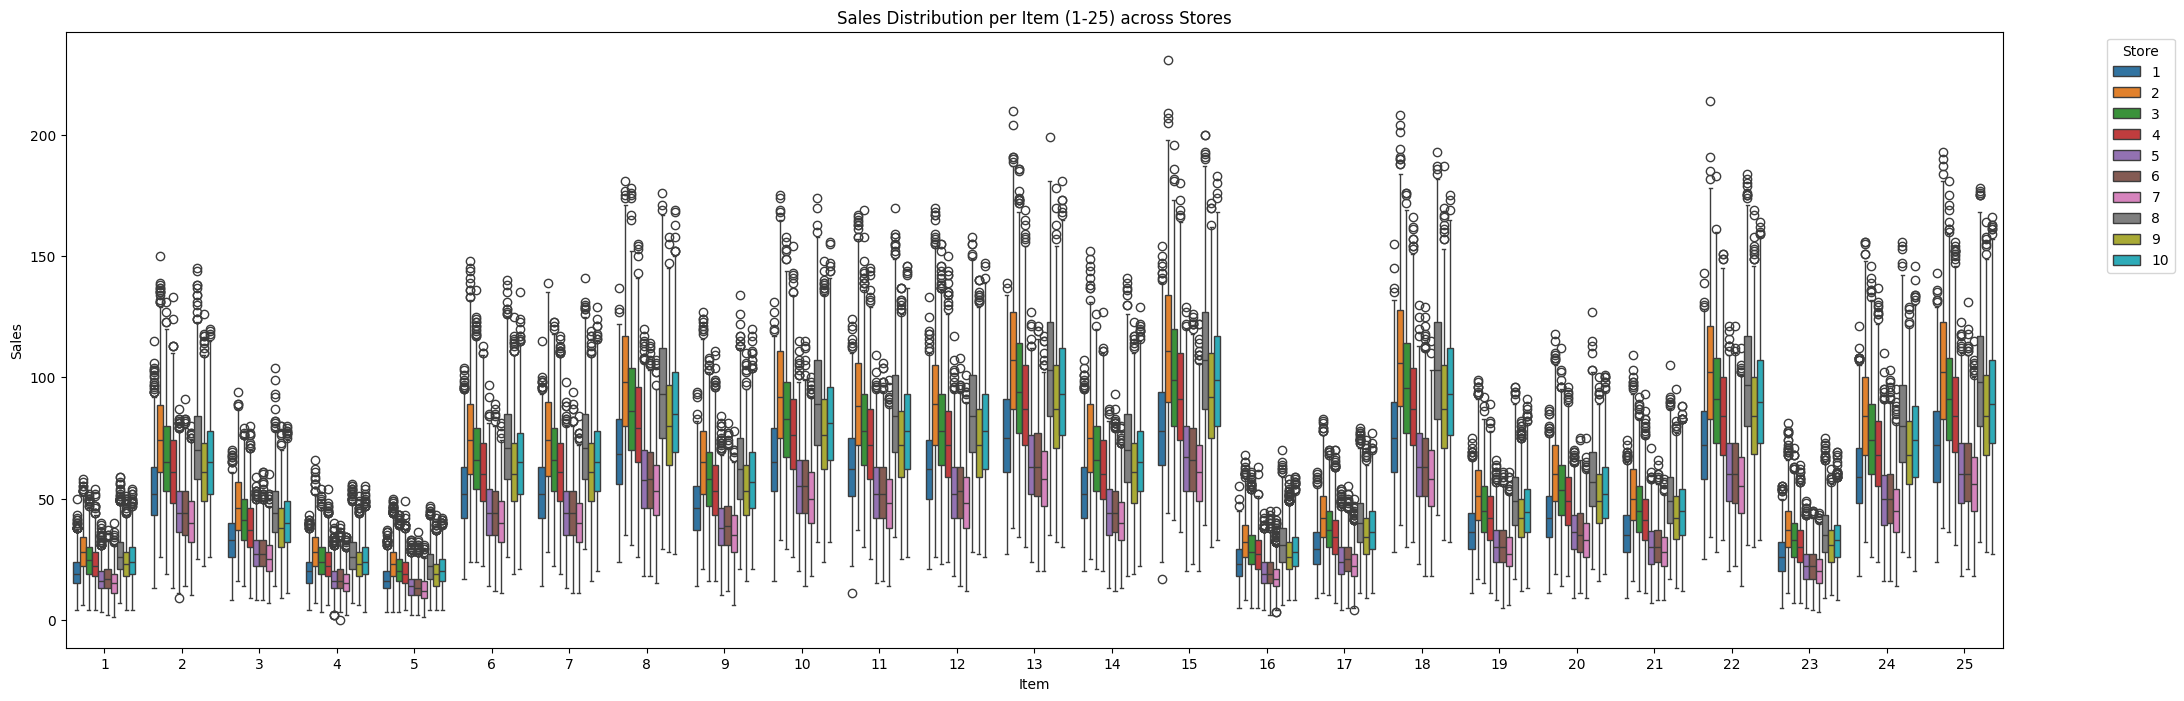

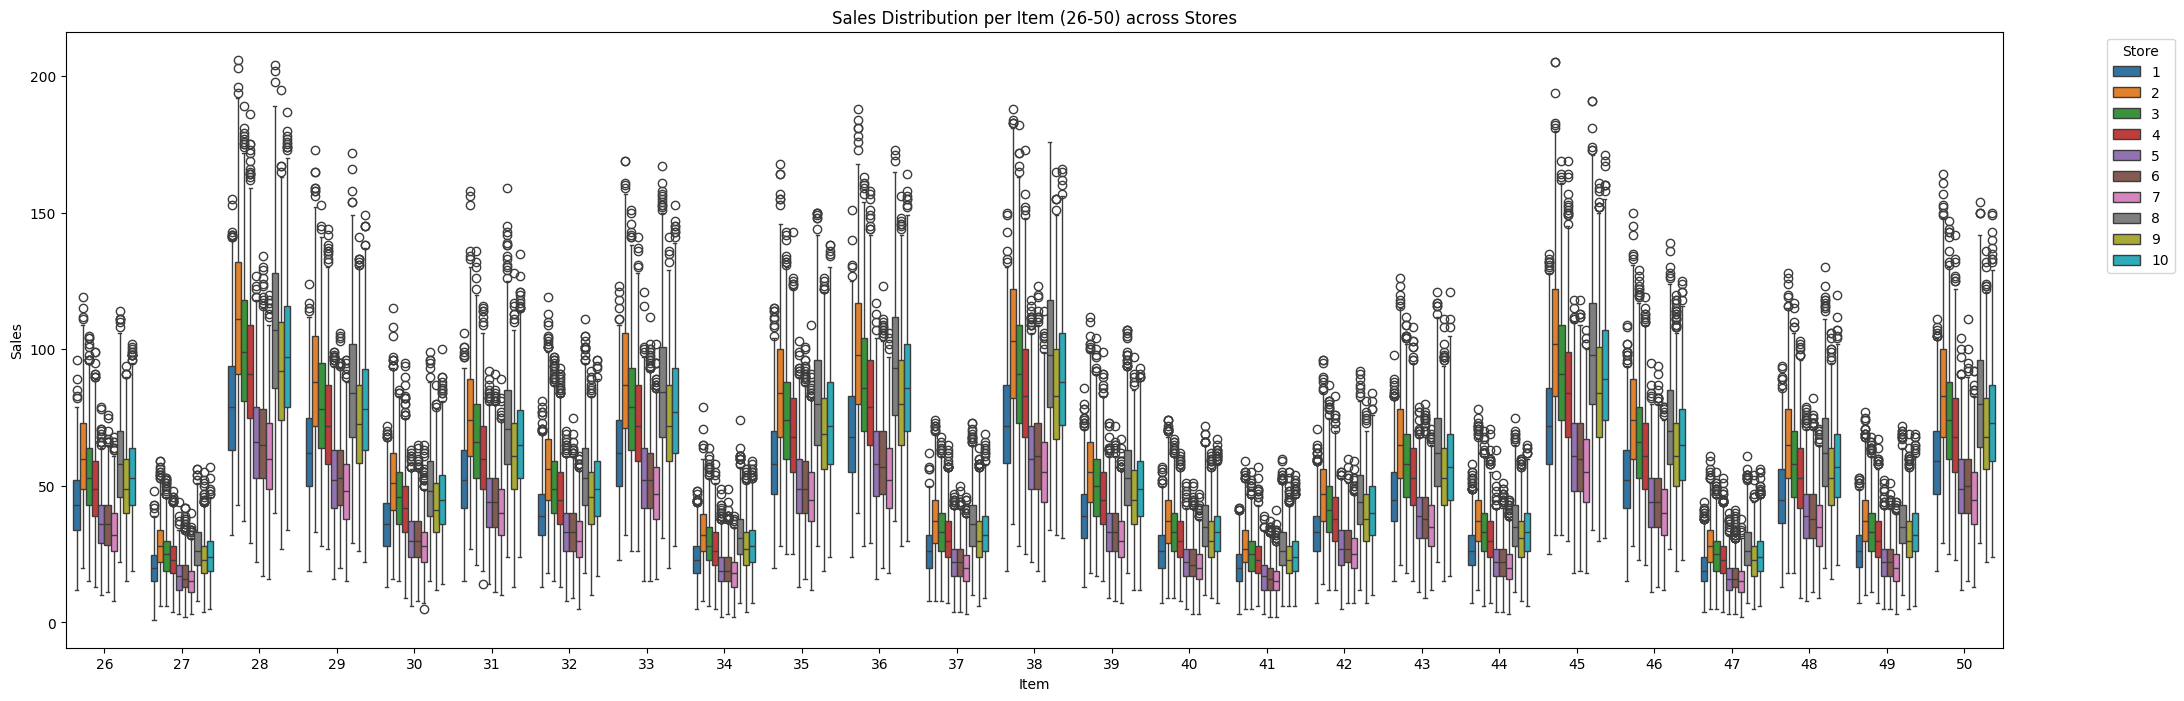

In [11]:
# Фільтрація даних для кожного діапазону item_id
data_1_25 = data[(data['item'] >= 1) & (data['item'] <= 25)]
data_26_50 = data[(data['item'] >= 26) & (data['item'] <= 50)]


# Побудова графіку для item_id 1-25
plt.figure(figsize=(25, 8))
sns.boxplot(data=data_1_25, x='item', y='sales', hue='store', palette='tab10')
plt.title('Sales Distribution per Item (1-25) across Stores')
plt.xlabel('Item')
plt.ylabel('Sales')
plt.legend(title='Store', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Побудова графіку для item_id 26-50
plt.figure(figsize=(25, 8))
sns.boxplot(data=data_26_50, x='item', y='sales', hue='store', palette='tab10')
plt.title('Sales Distribution per Item (26-50) across Stores')
plt.xlabel('Item')
plt.ylabel('Sales')
plt.legend(title='Store', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()




<ipython-input-12-f34d2ef56463>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='item', y='sales', palette='tab10')


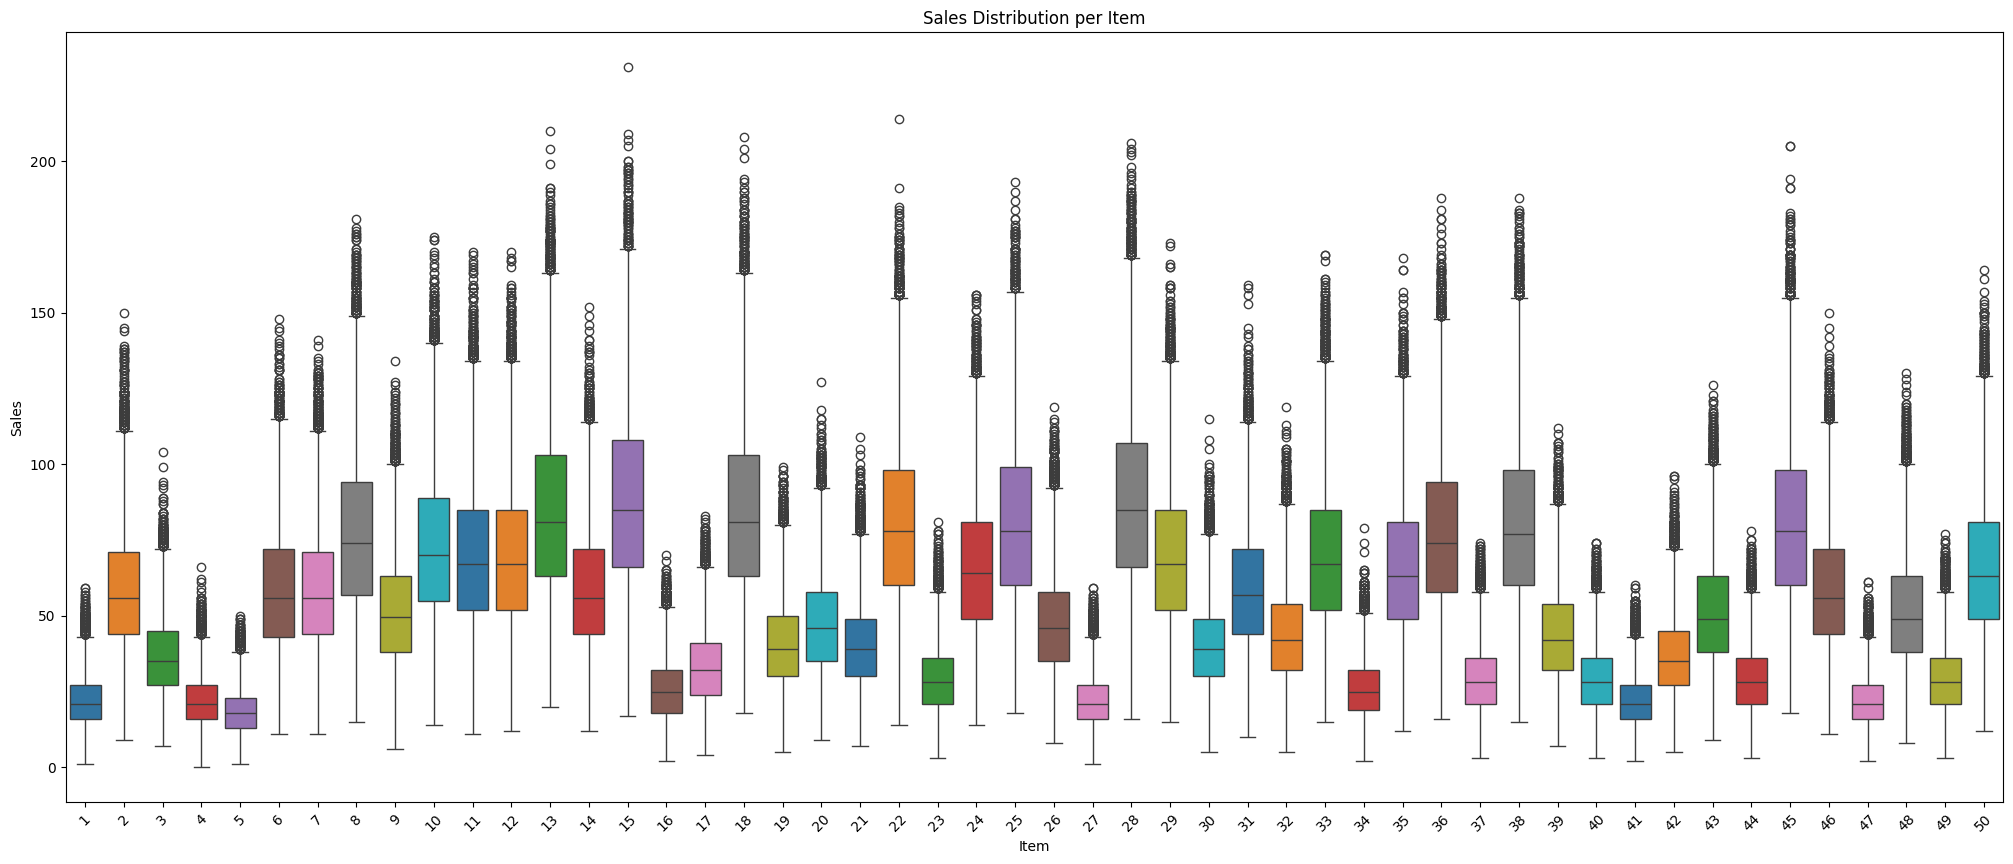

In [12]:
plt.figure(figsize=(25, 10))
sns.boxplot(data=data, x='item', y='sales', palette='tab10')
plt.title('Sales Distribution per Item')
plt.xlabel('Item')
plt.ylabel('Sales')
plt.xticks(rotation=45)  # Обертання міток на осі X для кращої читабельності
plt.show()

На цьому боксплоті можна побачити лідерів продаж, проте через велику кількість товарів, краще розглядати у парі з таблицею у якій вивести топ-10 товарів, які продаються, та топ 10, які найгірше продаються


In [13]:
# Групування даних за 'item' і обчислення середніх продажів для кожного айтему
item_sales_avg = data.groupby('item')['sales'].mean().reset_index()

# Сортування айтемів за середніми продажами в порядку спадання
item_sales_sorted = item_sales_avg.sort_values(by='sales', ascending=False)

# Вибір топ-10 товарів з найкращим середнім продажем
top_10_best_selling = item_sales_sorted.head(10)

# Вибір топ-10 товарів з найгіршим середнім продажем
top_10_worst_selling = item_sales_sorted.tail(10)

# Об'єднання двох таблиць для зручності
top_10_combined = pd.concat([top_10_best_selling, top_10_worst_selling], axis=0)

print("\nОб'єднана таблиця топ-10 найкращих та найгірших товарів за середніми продажами:")
print(top_10_combined)



Об'єднана таблиця топ-10 найкращих та найгірших товарів за середніми продажами:
    item      sales
14    15  88.030778
27    28  87.881325
12    13  84.316594
17    18  84.275794
24    25  80.686418
44    45  80.584173
37    38  80.521906
21    22  80.502245
35    36  77.028916
7      8  76.950055
36    37  29.258379
39    40  29.249398
33    34  25.735761
15    16  25.656079
26    27  22.049726
3      4  22.010241
46    47  22.003341
40    41  22.002136
0      1  21.981599
4      5  18.358708


\3. **Для початку проаналізуємо лише один ряд**
  
  Виберу підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Роблю декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.


In [14]:
data_i1_s1 = data[(data['item'] == 1) & (data['store'] == 1)]

In [15]:
df_i1_s1_additive = data_i1_s1.copy(deep=True)

# рахуємо тренд згладжуючи ряд з річним вікном розміром 50
df_i1_s1_additive["trend"] = df_i1_s1_additive["sales"].rolling(window=365, center=True).mean()

# віднімаємо тренд з даних
df_i1_s1_additive["detrended"] = df_i1_s1_additive["sales"] - df_i1_s1_additive["trend"]

# рахуємо сезонну складову як середнє значення ряду пілся віднімання тренду
df_i1_s1_additive["month"] = df_i1_s1_additive.index.month
df_i1_s1_additive["seasonality"] = df_i1_s1_additive.groupby("month")["detrended"].transform("mean")

# обчислюємо залишок як все, що ми не змогли пояснити сезонністю
df_i1_s1_additive["resid"] = df_i1_s1_additive["detrended"] - df_i1_s1_additive["seasonality"]

# що у нас вийшло в результаті
df_i1_s1_additive.head(10)

,store,item,sales,trend,detrended,month,seasonality,resid
date,,,,,,,,
2013-01-01,1,1,13,NaN,NaN,1,-5.706695,NaN
2013-01-02,1,1,11,NaN,NaN,1,-5.706695,NaN
2013-01-03,1,1,14,NaN,NaN,1,-5.706695,NaN
2013-01-04,1,1,13,NaN,NaN,1,-5.706695,NaN
2013-01-05,1,1,10,NaN,NaN,1,-5.706695,NaN
2013-01-06,1,1,12,NaN,NaN,1,-5.706695,NaN
2013-01-07,1,1,10,NaN,NaN,1,-5.706695,NaN
2013-01-08,1,1,9,NaN,NaN,1,-5.706695,NaN
2013-01-09,1,1,12,NaN,NaN,1,-5.706695,NaN


<Axes: xlabel='date'>

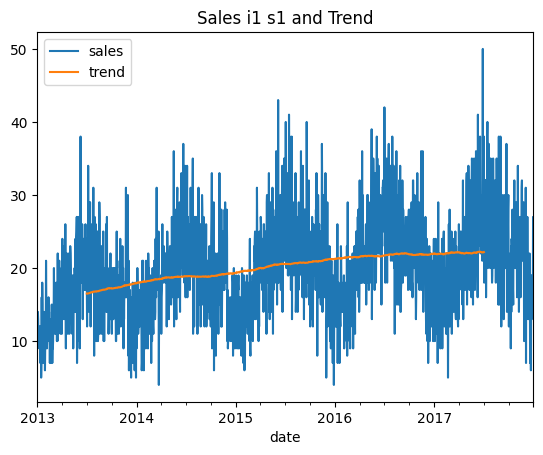

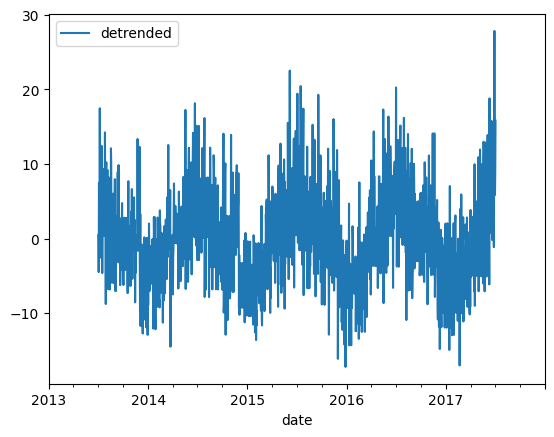

In [16]:
df_i1_s1_additive["trend"] = df_i1_s1_additive["sales"].rolling(window=365, center=True).mean()


df_i1_s1_additive[["sales", "trend"]].plot()
plt.title("Sales i1 s1 and Trend")

df_i1_s1_additive[["detrended"]].plot()

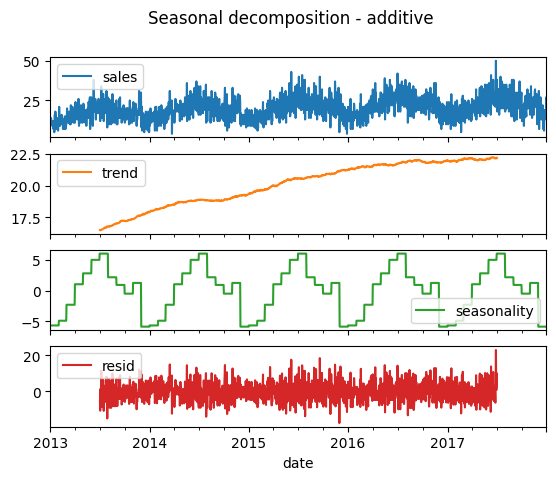

In [17]:
(
    df_i1_s1_additive
    .loc[:, ["sales", "trend", "seasonality", "resid"]]
    .plot(subplots=True, title="Seasonal decomposition - additive")
);

Видно, що тренд злегка зростає, є річна сезональність, яка має найнижчі продажі у період новорічних свят, пік продаж приблизно літом
Оскільки дані в нас поденні, то розмір вікна вибрав 1 рік(365 днів)

4. Зі створеної підможини даних в попередньому пункті створюю обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [18]:
pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.2/934.2 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.4/271.4 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.7 MB/s eta 0:00:

In [19]:
from darts import TimeSeries

series_sales_i1_s1 = TimeSeries.from_dataframe(data_i1_s1, value_cols='sales')

In [20]:
series_sales_i1_s1

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='date'>

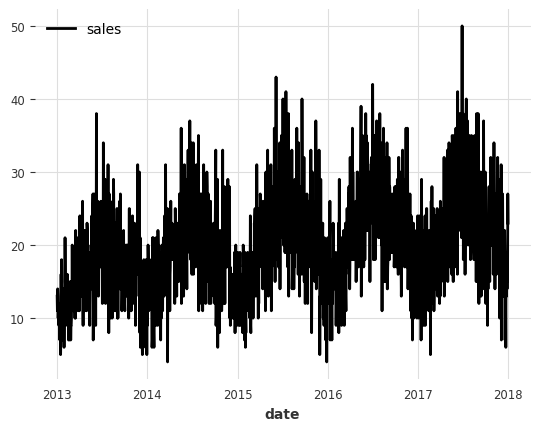

In [21]:
series_sales_i1_s1.plot()

5. Використовуючи метод `series.split_before` розбиваю дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізовую на одному графіку тренувальну і валідаційну частину як було показано в лекції.

In [22]:
series_sales_i1_s1_train, series_sales_i1_s1_val = series_sales_i1_s1.split_before(pd.Timestamp('2017-10-01'))

In [23]:
series_sales_i1_s1_train

<TimeSeries (DataArray) (date: 1734, component: 1, sample: 1)> Size: 14kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[23.]],

       [[28.]],

       [[30.]]])
Coordinates:
  * date       (date) datetime64[ns] 14kB 2013-01-01 2013-01-02 ... 2017-09-30
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='date'>

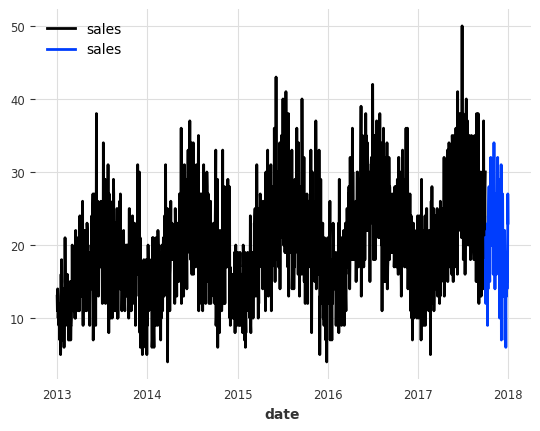

In [24]:
series_sales_i1_s1_train.plot()
series_sales_i1_s1_val.plot()

6. Побудую часткову автокореляційну фукнцію для цього нашого ряду в `series`.

In [25]:
print(type(series_sales_i1_s1))

<class 'darts.timeseries.TimeSeries'>


In [26]:
series_sales_i1_s1

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [27]:
series_sales_i1_s1_pd = series_sales_i1_s1.pd_series()
print(series_sales_i1_s1_pd.head())

date
2013-01-01    13.0
2013-01-02    11.0
2013-01-03    14.0
2013-01-04    13.0
2013-01-05    10.0
Freq: D, Name: sales, dtype: float64


<Figure size 1000x600 with 0 Axes>

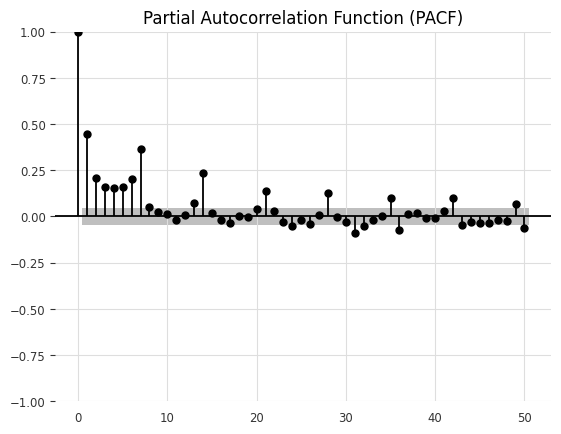

In [28]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(10, 6))
plot_pacf(series_sales_i1_s1_pd, lags=50, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

Є сильна автокореляція з першим лагом. Це свідчить про те, що дані сильно корелюють з попереднім значенням.
Також значущі лаги 1-8, 14, 21, 28, 31, 36 та 41.
Потенційно значущі лаги на межі довірчого інтервалу 13 та 49, 50.


7. Виявляю сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

Також візуалізую визначену сезонність.

In [29]:
from darts.utils.statistics import plot_acf, check_seasonality

for m in range(2, 25):
    is_seasonal, period = check_seasonality(series_sales_i1_s1_train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


Сезонність 7

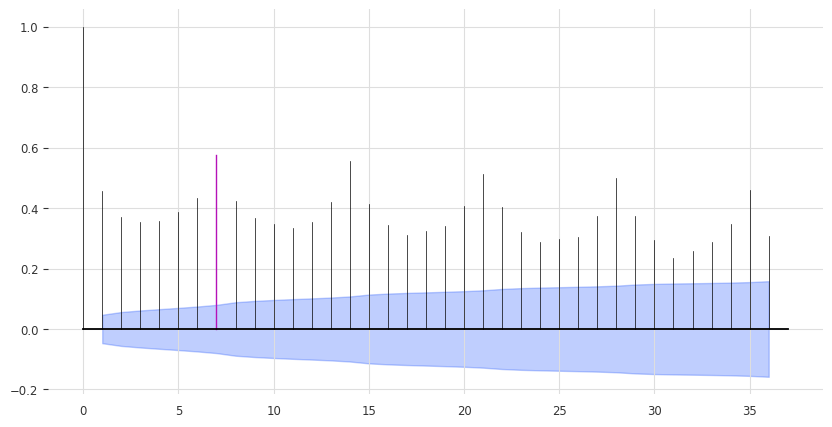

In [30]:
plot_acf(series_sales_i1_s1_train, m=7, alpha=0.05, max_lag=36)

8. Побудую наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначаю зі свого аналізу в попередніх пунктах.
Візуалізую передбачення на фоні справжніх даних так, аби було видно якість передбачень.


In [31]:
from darts.models import NaiveSeasonal

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [32]:
start_date = pd.Timestamp('2017-01-01')
end_date = pd.Timestamp('2017-12-31')
filtered_series_i1_s1 = series_sales_i1_s1.slice(start_date, end_date)

<Axes: xlabel='date'>

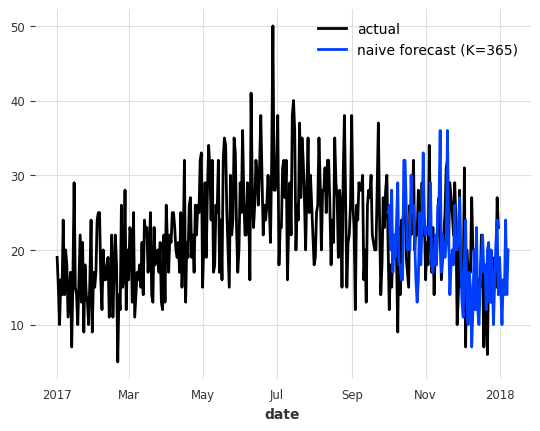

In [33]:
naive_model = NaiveSeasonal(K=365)
naive_model.fit(series_sales_i1_s1_train)
naive_forecast = naive_model.predict(100)

filtered_series_i1_s1.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=365)")

При річній сезонності модель NaiveSeasonal доволі не погано прогнозує на перший погляд.

<Axes: xlabel='date'>

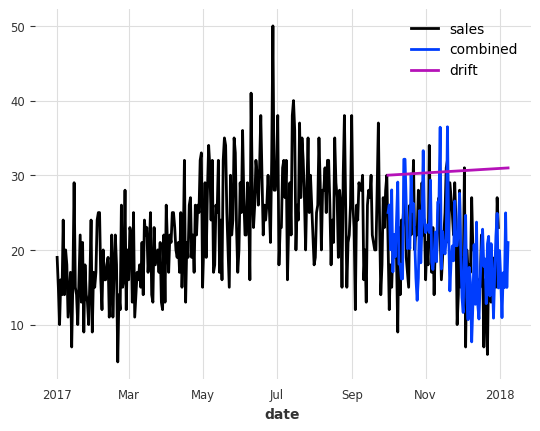

In [34]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(series_sales_i1_s1_train)
drift_forecast = drift_model.predict(100)

combined_forecast = drift_forecast + naive_forecast - series_sales_i1_s1_train.last_value()

filtered_series_i1_s1.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

NaiveDrift при окремому використанні взагалі не попадає в передбачення і захопилась загальним трендом

9. Візуальний аналіз це добре і гарно, але потрібно обчислити помилку прогнозу на валідації наївною моделлю з метрикою MAPE.

In [35]:
from darts.metrics import mape

In [36]:
print(
    f"Mean absolute percentage error for the combined naive drift + seasonal: {mape(series_sales_i1_s1_val, combined_forecast):.4f}%."
)

Mean absolute percentage error for the combined naive drift + seasonal: 34.2589%.


In [37]:
print(
    f"Mean absolute percentage error for the naive drift: {mape(series_sales_i1_s1_val, drift_forecast):.4f}%."
)

Mean absolute percentage error for the naive drift: 68.7441%.


In [38]:
print(
    f"Mean absolute percentage error for the seasonal: {mape(series_sales_i1_s1_val, naive_forecast):.4f}%."
)

Mean absolute percentage error for the seasonal: 33.9227%.


NaiveDrift - дуже велика помилка, погано передбачає
NaiveSeasonal та combined - помилки з не великою різницею та всеодно не те, що хотілось би прогнозувати з такою точністю.

10. Натреную XBGModel з `darts` для передбачення на наших даних.
Також додам додаткові ознаки для цієї моделі.

In [39]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

In [40]:
series_sales_i1_s1_train

<TimeSeries (DataArray) (date: 1734, component: 1, sample: 1)> Size: 14kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[23.]],

       [[28.]],

       [[30.]]])
Coordinates:
  * date       (date) datetime64[ns] 14kB 2013-01-01 2013-01-02 ... 2017-09-30
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [41]:
def enrich_with_date_features(df):
  # Feature Extraction
  # df["hour"] = df['Month'].dt.hour
  df["dayofweek"] = df['date'].dt.dayofweek
  df["quarter"] = df['date'].dt.quarter
  df["month"] = df['date'].dt.month
  df["year"] = df['date'].dt.year
  df["dayofyear"] = df['date'].dt.dayofyear
  df["sin_day"] = np.sin(df["dayofyear"])
  df["cos_day"] = np.cos(df["dayofyear"])
  # df["dayofmonth"] = df['Month'].dt.day
  return df

# Додавання ознак дати
train_transformed = enrich_with_date_features(series_sales_i1_s1_train.pd_dataframe().reset_index())
val_transformed = enrich_with_date_features(series_sales_i1_s1_val.pd_dataframe().reset_index())

In [42]:
# Масштабування даних
scaler = Scaler()
train_transformed = scaler.fit_transform(series_sales_i1_s1_train)
val_transformed = scaler.transform(series_sales_i1_s1_val)

# Побудова моделі XGBoost
model = XGBModel(
    lags=365,  # Використання останніх 365 спостережень для прогнозування
    output_chunk_length=1,  # Прогнозування на 1 крок вперед
    n_estimators=200,  # Кількість дерев у моделі
    max_depth=4,  # Максимальна глибина кожного дерева
    learning_rate=0.05,  # Коефіцієнт навчання
    subsample=0.8,  # Частка даних для випадкової вибірки кожного дерева
    colsample_bytree=0.8  # Частка ознак, що використовуються для кожного дерева
)

# Тренування моделі
model.fit(train_transformed)
pred = model.predict(100)
pred.values()

array([[0.5755231 ],
       [0.32587802],
       [0.37846676],
       [0.35064387],
       [0.40680566],
       [0.4586117 ],
       [0.5231859 ],
       [0.5092638 ],
       [0.30425903],
       [0.34187287],
       [0.36969975],
       [0.44417968],
       [0.5036001 ],
       [0.53365505],
       [0.5480739 ],
       [0.32110724],
       [0.3777863 ],
       [0.38515997],
       [0.4360449 ],
       [0.4991322 ],
       [0.4852571 ],
       [0.4937801 ],
       [0.28546202],
       [0.3421841 ],
       [0.35136425],
       [0.42242154],
       [0.4566552 ],
       [0.5453102 ],
       [0.49901924],
       [0.3035766 ],
       [0.38481545],
       [0.3780644 ],
       [0.39078888],
       [0.4233135 ],
       [0.49143398],
       [0.49056917],
       [0.27177608],
       [0.32853672],
       [0.3569506 ],
       [0.38962406],
       [0.50019574],
       [0.4811943 ],
       [0.50301445],
       [0.33194387],
       [0.34653696],
       [0.33757415],
       [0.3716972 ],
       [0.397

In [43]:
train_transformed

<TimeSeries (DataArray) (date: 1734, component: 1, sample: 1)> Size: 14kB
array([[[0.19565217]],

       [[0.15217391]],

       [[0.2173913 ]],

       ...,

       [[0.41304348]],

       [[0.52173913]],

       [[0.56521739]]])
Coordinates:
  * date       (date) datetime64[ns] 14kB 2013-01-01 2013-01-02 ... 2017-09-30
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [44]:
scaler.inverse_transform(pred)

<TimeSeries (DataArray) (date: 100, component: 1, sample: 1)> Size: 400B
array([[[30.47406 ]],

       [[18.990389]],

       [[21.409472]],

       [[20.129618]],

       [[22.71306 ]],

       [[25.096138]],

       [[28.066551]],

       [[27.426134]],

       [[17.995916]],

       [[19.726152]],

...

       [[17.062723]],

       [[23.377298]],

       [[12.388563]],

       [[13.07582 ]],

       [[16.533468]],

       [[16.505428]],

       [[18.067421]],

       [[19.267187]],

       [[21.910398]],

       [[12.246554]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 800B 2017-10-01 2017-10-02 ... 2018-01-08
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

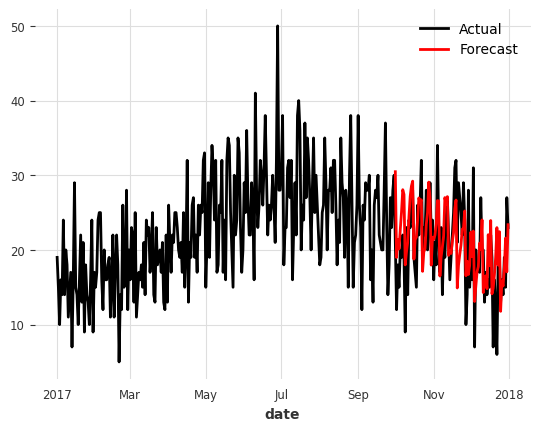

In [45]:
forecast = scaler.inverse_transform(model.predict(len(series_sales_i1_s1_val)))
filtered_series_i1_s1.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()


In [46]:
print(
    f"Mean absolute percentage error for the XGBoost: {mape(series_sales_i1_s1_val, forecast):.4f}%."
)

Mean absolute percentage error for the XGBoost: 25.4209%.


У попередніх моделях найкращий результат був 33,92, а XGBoost дає 25,42, що вже суттєво краще. Модель гарно зловила сезонність.

12. Натреную модель ARIMA з різними параметрами.

In [47]:
def fit_and_plot(model, series, train, val):
  model.fit(train)
  forecast = model.predict(len(val))
  plot_results(series, forecast)
  eval_forecast(model, val, forecast);

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Mean absolute percentage error for the ARIMA: 36.3361%.


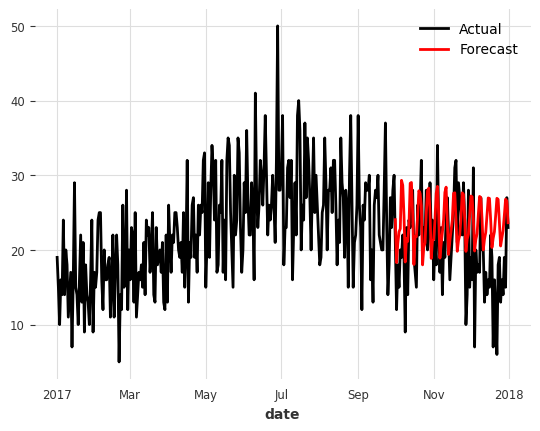

In [48]:
from darts.models import ARIMA

model = ARIMA(p=52, d=1, q=1) # try p=52
model.fit(series_sales_i1_s1_train)
forecast = model.predict(len(series_sales_i1_s1_val))
filtered_series_i1_s1.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
print(
    f"Mean absolute percentage error for the ARIMA: {mape(series_sales_i1_s1_val, forecast):.4f}%."
)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Mean absolute percentage error for the ARIMA: 39.5282%.


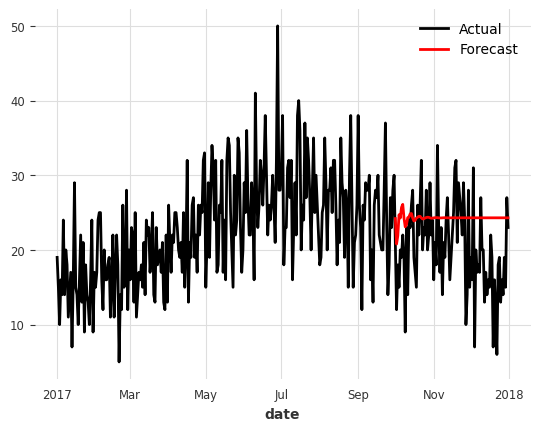

In [49]:
model = ARIMA(p=7, d=1, q=1) # try p=7
model.fit(series_sales_i1_s1_train)
forecast = model.predict(len(series_sales_i1_s1_val))
filtered_series_i1_s1.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
print(
    f"Mean absolute percentage error for the ARIMA: {mape(series_sales_i1_s1_val, forecast):.4f}%."
)

З параметром р=52 модель краще прогнозує, проте дуже довго виконується обчислення на CPU. Можливо, якщо підключити GPU то виконається швидше, проте в цьому випадку(на цьому часовому ряді) швидше за все сенсу немає.
З параметром p=7 результати ще гірші
Загалом ARIMA не дуже справляється та не враховує сезонність.

13. Спробую знайти оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконаю пошук параметрів, виведу, які парметри виявились оптимальними і обчислю якість моделі.

In [50]:
from darts.models import AutoARIMA

AutoARIMA(add_encoders=None, start_p=5, max_p=55, start_q=1)

Mean absolute percentage error for the AutoARIMA: 39.5282%.


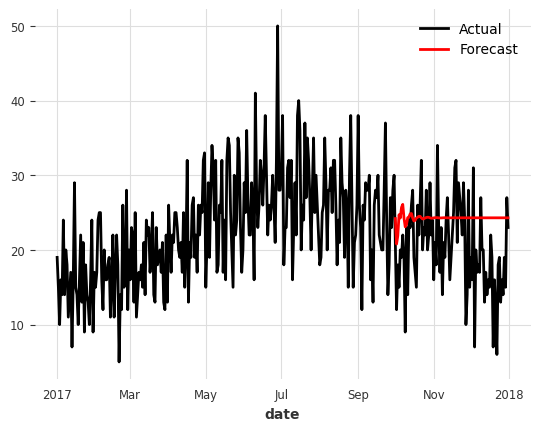

In [51]:
model = AutoARIMA(start_p=5, max_p=55, start_q=1) # спробую стартувати з інших значень
model.fit(series_sales_i1_s1_train)

display(model)

forecast = model.predict(len(series_sales_i1_s1_val))
filtered_series_i1_s1.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
print(
    f"Mean absolute percentage error for the AutoARIMA: {mape(series_sales_i1_s1_val, forecast):.4f}%."
)

In [52]:
model.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1734
Model:               SARIMAX(7, 1, 1)   Log Likelihood               -5286.539
Date:                Thu, 31 Oct 2024   AIC                          10591.078
Time:                        10:53:55   BIC                          10640.196
Sample:                             0   HQIC                         10609.244
                               - 1734                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0346      0.038      0.904      0.366      -0.040       0.109
ar.L2         -0.0799      0.034     -2.379      0.017      -0.146      -0.014
ar.L3         -0.0775      0.033     -2.316      0.021      -0.143      -0.012
ar.L4         -0.0651      0.034     -1.939      0.053      -0.131       0.001
ar.L5         -0.0342      0.032     -1.063      0.288      -0.097       0.029
ar.L6          0.0062      0.030      0.207      0.836      -0.053       0.065
ar.L7          0.2638      0.029      9.042      0.000       0.207       0.321
ma.L1         -0.9071      0.026    -34.233      0.000      -0.959      -0.855
sigma2        26.0956      0.820     31.811      0.000      24.488      27.703
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.19
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Результат вийшов таким самим як ARIMA(7, 1, 1) що і показало Summary.
Arima просто не підходить під цей випадок TimeSeries.

14. Натреную модель Prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmgsy6u2a/jb2n2bvh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmgsy6u2a/lu7w6cgp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4786', 'data', 'file=/tmp/tmpmgsy6u2a/jb2n2bvh.json', 'init=/tmp/tmpmgsy6u2a/lu7w6cgp.json', 'output', 'file=/tmp/tmpmgsy6u2a/prophet_modelsxff3h58/prophet_model-20241031105356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:53:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:53:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


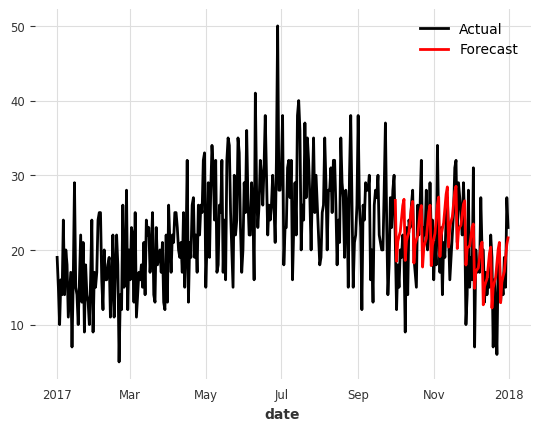

In [53]:
from darts.models import Prophet

# Побудова та тренування моделі Prophet
model = Prophet()
model.fit(series_sales_i1_s1_train)

# Прогнозування
forecast = model.predict(len(series_sales_i1_s1_val))

# Візуалізація результатів
filtered_series_i1_s1.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

In [54]:
print(
    f"Mean absolute percentage error for the Prophet: {mape(series_sales_i1_s1_val, forecast):.4f}%."
)

Mean absolute percentage error for the Prophet: 23.8048%.


Судячи з візуалізації модель досить гарно прогнозує, вловлює тренд, але не вловилює можливість "викидів" чи значень, які вибиваються з тренду і залишається на рівні середнього діапазону прогнозів.
Поки що Prophet найкраще прогнозкє для цього TimeSeries

15. Натреную модель `RNNModel`

In [55]:
from darts.models import RNNModel

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

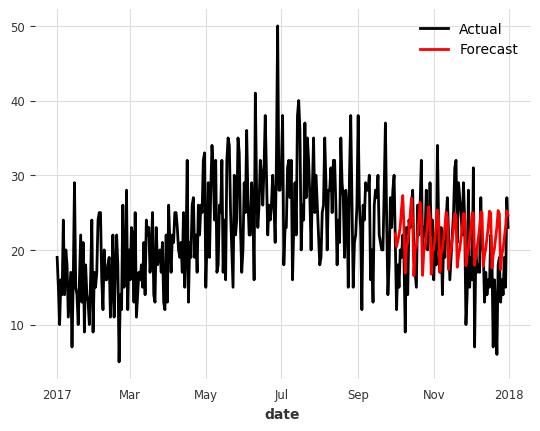

In [56]:
# Побудова та тренування моделі LSTM
model = RNNModel(model='LSTM', input_chunk_length=7, n_epochs=300)
model.fit(series_sales_i1_s1_train)

# Прогнозування
forecast = model.predict(len(series_sales_i1_s1_val))

# Візуалізація результатів
filtered_series_i1_s1.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

In [58]:
print(
    f"Mean absolute percentage error for the RNNModel: {mape(series_sales_i1_s1_val, forecast):.4f}%."
)

Mean absolute percentage error for the RNNModel: 23.8048%.


RNN не дуже спрацювала, не бачить сезонності ічерез те і помилка висока в неї виходить.

16. Виконаю бектест для тої моделі, яка виявилась найкращою на дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу.

In [57]:
model = Prophet()
model.fit(series_sales_i1_s1_train)

forecast = model.predict(len(series_sales_i1_s1_val))

print(
    f"Mean absolute percentage error for the RNNModel: {mape(series_sales_i1_s1_val, forecast):.4f}%."
)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmgsy6u2a/k_8qo8hd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmgsy6u2a/ckjhvxqe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53633', 'data', 'file=/tmp/tmpmgsy6u2a/k_8qo8hd.json', 'init=/tmp/tmpmgsy6u2a/ckjhvxqe.json', 'output', 'file=/tmp/tmpmgsy6u2a/prophet_modelj7ka0giv/prophet_model-20241031110401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:04:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:04:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean absolute percentage error for the RNNModel: 23.8048%.


  0%|          | 0/275 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmgsy6u2a/o9z54zli.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmgsy6u2a/2j1gw6l6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30753', 'data', 'file=/tmp/tmpmgsy6u2a/o9z54zli.json', 'init=/tmp/tmpmgsy6u2a/2j1gw6l6.json', 'output', 'file=/tmp/tmpmgsy6u2a/prophet_modelwa1ujz3e/prophet_model-20241031113116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:31:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  0%|          | 1/275 [00:00<03:15,  1.40it/s]INFO:prophet:Disabling daily seasonality. Run prophet wi

MAPE = 20.48%


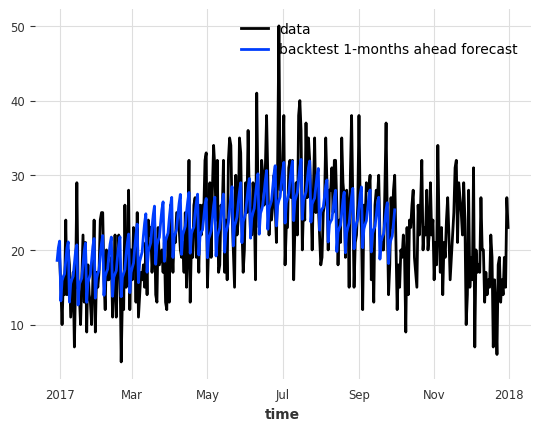

In [69]:
hfc_params = {
    "series": series_sales_i1_s1_train,
    "start": pd.Timestamp("2016-12-01"),
    "forecast_horizon": 30,
    "verbose": True,
}

historical_fcast = model.historical_forecasts(last_points_only=True, **hfc_params)

filtered_series_i1_s1.plot(label="data")
historical_fcast.plot(label="backtest 1-months ahead forecast")
print(f"MAPE = {mape(series_sales_i1_s1, historical_fcast):.2f}%")

Вийшло, досить непогано. Модель попадає у сезонність, трохи недозахоплює варіативність. MAPE покращився і став 20,48 з 25+

Напишу функцію для створення 5 датасетів випадковим чином вибраних магазинів та товарів у них.

In [60]:
import random

def generate_random_dataframes(data, n=5):
    variables = {}
    for i in range(1, n + 1):
        random_store = random.randint(1, 10)  # Випадковий магазин (1-10)
        random_item = random.randint(1, 50)   # Випадковий товар (1-50)

        # Формування датасету для обраного товару та магазину
        subset = data[(data['item'] == random_item) & (data['store'] == random_store)]

        # Назва змінної у форматі data_i{item}_s{store}
        var_name = f"data_i{random_item}_s{random_store}"
        variables[var_name] = subset

    return variables


Створюю словник з поділених Timeseries

In [67]:
# Використання функції для створення словника з датасетами
data_dict = generate_random_dataframes(data)

# Ініціалізація словника для об'єктів TimeSeries
time_series_dict = {}

# Перетворення кожного датасету у об'єкт TimeSeries
for var_name, df in data_dict.items():
    # Зберігаємо ту ж назву змінної для об'єкта TimeSeries
    time_series_dict[var_name] = TimeSeries.from_dataframe(df, value_cols='sales')

Тепер потрібно поділити Timeseries у словнику на тренувальні та валідаційні відповідно для кожного товару.

In [70]:
# Ініціалізація словника для train та val серій
split_series_dict = {}

# Дата розділення
split_date = pd.Timestamp('2017-10-01')

# Поділ кожного об'єкта TimeSeries на train і val
for var_name, series in time_series_dict.items():
    # Поділ серії
    train_series, val_series = series.split_before(split_date)

    # Додавання train та val до нового словника з новими назвами ключів
    split_series_dict[f"{var_name}_train"] = train_series
    split_series_dict[f"{var_name}_val"] = val_series

# Тепер split_series_dict містить train та val серії для кожного товару і магазину


І тепер через цикл роблю передбачення з візуалізацією прогнозів та виведенням помилки по кожному з Timeseries.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmgsy6u2a/j9aecp6k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmgsy6u2a/u_1giq9j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61708', 'data', 'file=/tmp/tmpmgsy6u2a/j9aecp6k.json', 'init=/tmp/tmpmgsy6u2a/u_1giq9j.json', 'output', 'file=/tmp/tmpmgsy6u2a/prophet_modelumm9tqa4/prophet_model-20241031114327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:43:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:43:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean absolute percentage error for data_i10_s9: 11.0316%


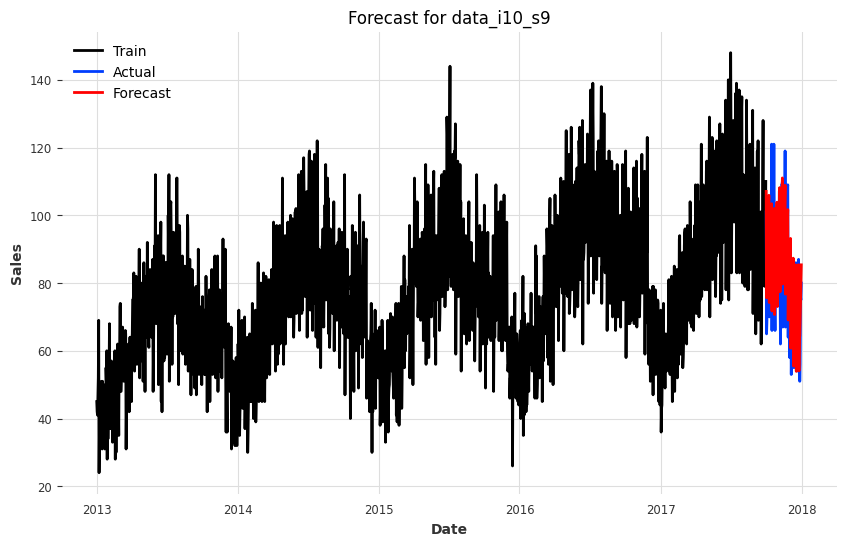

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmgsy6u2a/psdjkolw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmgsy6u2a/lzm2nm12.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36942', 'data', 'file=/tmp/tmpmgsy6u2a/psdjkolw.json', 'init=/tmp/tmpmgsy6u2a/lzm2nm12.json', 'output', 'file=/tmp/tmpmgsy6u2a/prophet_model1oetkazt/prophet_model-20241031114330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:43:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:43:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean absolute percentage error for data_i41_s6: 22.8653%


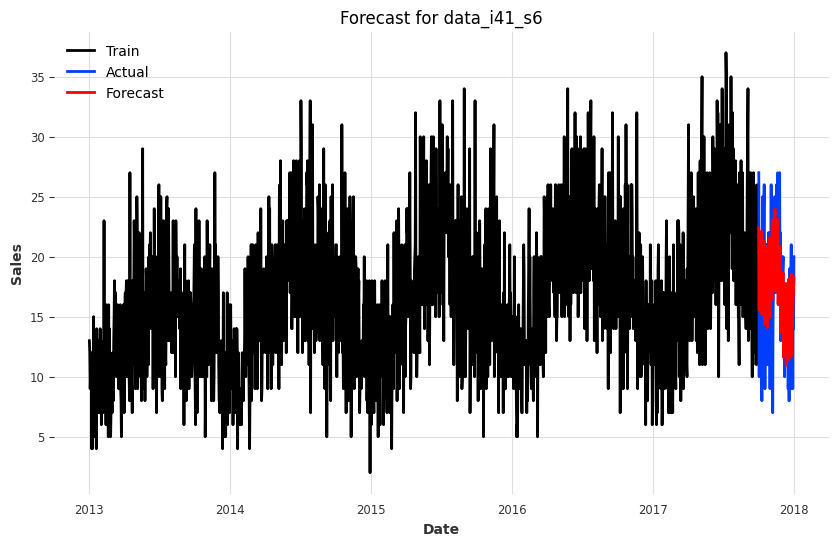

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmgsy6u2a/b_mpd9rd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmgsy6u2a/jtfdfurv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7920', 'data', 'file=/tmp/tmpmgsy6u2a/b_mpd9rd.json', 'init=/tmp/tmpmgsy6u2a/jtfdfurv.json', 'output', 'file=/tmp/tmpmgsy6u2a/prophet_modeltgjo2um2/prophet_model-20241031114335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:43:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:43:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean absolute percentage error for data_i34_s2: 15.7620%


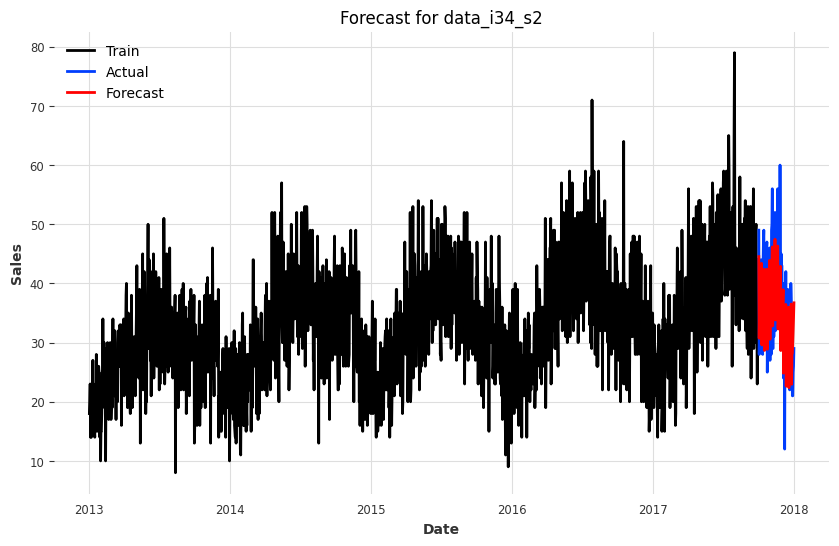

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmgsy6u2a/0zb2vcns.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmgsy6u2a/xi14d0id.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6943', 'data', 'file=/tmp/tmpmgsy6u2a/0zb2vcns.json', 'init=/tmp/tmpmgsy6u2a/xi14d0id.json', 'output', 'file=/tmp/tmpmgsy6u2a/prophet_modely8f_y_d6/prophet_model-20241031114335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:43:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:43:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean absolute percentage error for data_i5_s3: 17.8080%


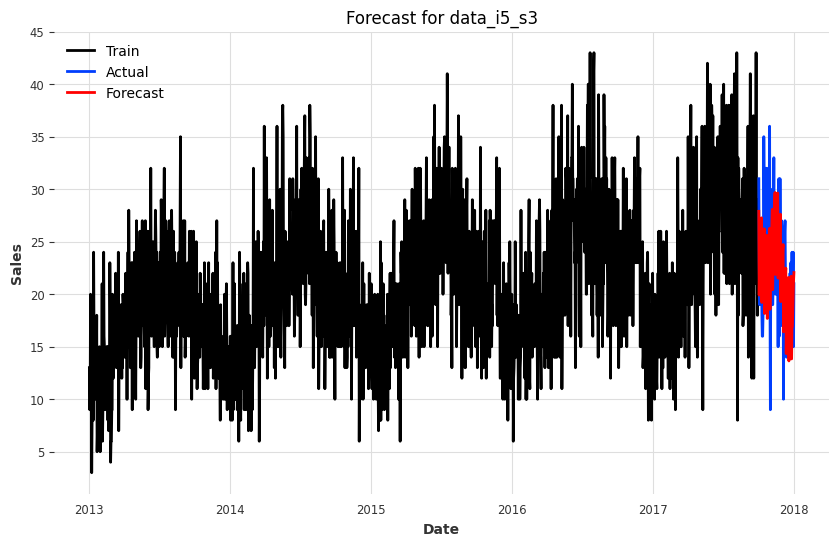

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmgsy6u2a/e3zztq58.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmgsy6u2a/3096egsu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20527', 'data', 'file=/tmp/tmpmgsy6u2a/e3zztq58.json', 'init=/tmp/tmpmgsy6u2a/3096egsu.json', 'output', 'file=/tmp/tmpmgsy6u2a/prophet_modelwu06rn_i/prophet_model-20241031114336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:43:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:43:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean absolute percentage error for data_i48_s2: 10.8025%


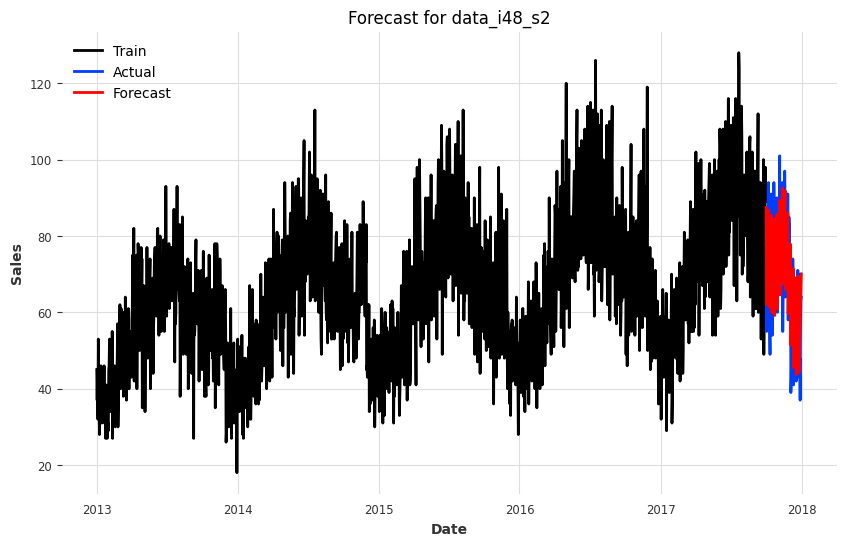

In [73]:
# Ітерація по кожній парі train/val серій у словнику
for var_name, train_series in split_series_dict.items():
    # Перевіряємо, чи це train серія
    if "_train" in var_name:
        # Знаходимо відповідну val серію
        val_series_name = var_name.replace("_train", "_val")
        val_series = split_series_dict.get(val_series_name)

        if val_series is not None:
            # Побудова та тренування моделі Prophet
            model = Prophet()
            model.fit(train_series)  # Передаємо TimeSeries напряму

            # Прогнозування на період довжиною val серії
            forecast = model.predict(len(val_series))

            # Обчислення MAPE для val серії
            error = mape(val_series, forecast)
            print(f"Mean absolute percentage error for {var_name.replace('_train', '')}: {error:.4f}%")

            # Візуалізація результатів
            plt.figure(figsize=(10, 6))
            train_series.plot(label='Train')
            val_series.plot(label='Actual')
            forecast.plot(label='Forecast', color='red')
            plt.title(f"Forecast for {var_name.replace('_train', '')}")
            plt.xlabel('Date')
            plt.ylabel('Sales')
            plt.legend()
            plt.show()
